### Import Libraries & Load Data

In [29]:
import numpy as np
import pandas as pd
import math

# For statistical tests
from scipy import stats
from sklearn.model_selection import train_test_split

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

cmap = cm.get_cmap('gnuplot')
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('Fraud_Data.csv')
ip_df = pd.read_csv('IpAddress_to_Country.csv')

### EDA

#### Features Addition

In [3]:
ip_df.upper_bound_ip_address.astype('float')
ip_df.lower_bound_ip_address.astype('float')

def ip_add_to_country(ip):
  try:
    return ip_df.country[(ip_df.lower_bound_ip_address < ip)                            
                                & 
                                (ip_df.upper_bound_ip_address > ip)].iloc[0]
  except:
    return "NA"
df["country"] = df.ip_address.apply(ip_add_to_country)

In [4]:
# get diff in days, time, seconds, quick_purchase from purchase_time and signup_time
df['diff_dt'] = (pd.to_datetime(df['purchase_time']) - pd.to_datetime(df['signup_time']))
df['days'] = df['diff_dt'].dt.days
# df['time'] = df['diff_dt'].astype(str).apply(lambda x : x[-8:])
# df["time"] = pd.to_datetime(df['time'],format= '%H:%M:%S' ).dt.time
df['seconds'] = df['diff_dt'].dt.total_seconds()
df['quick_purchase'] = df['seconds'].apply(lambda x: 1 if x < 30 else 0)

# get month, week, hour of the day from purchase_time
df['month_purchase'] = pd.to_datetime(df['purchase_time']).dt.strftime('%B')
df['weekday_purchase'] = pd.to_datetime(df['purchase_time']).dt.strftime('%A')
df['hour_of_the_day'] = pd.to_datetime(df['purchase_time']).dt.strftime('%H').astype(int)

# categorise hour of the day
df["period_of_the_day"] = df['hour_of_the_day'].apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

# get country risk from mean of class
risk_country = pd.DataFrame(df.groupby(by="country").mean()["class"].sort_values(ascending = False))
risk_country["risk_country"] = risk_country["class"].apply(lambda x:"High Risk" if x > 0.25 else "Medium Risk" if x > 0.10 else "Low Risk")
df = df.merge(risk_country.drop("class",axis=1),left_on='country', right_on = 'country')

# get count of duplicated devices
device_duplicates = df.groupby('device_id')['device_id'].count().rename('freq_device').reset_index()
df = df.merge(device_duplicates, on='device_id')
df['freq_device_cat'] = df['freq_device'].apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# get count of countries by device_id
country_count = df.groupby(["device_id", "country"])['country'].count().rename('country_count').reset_index()
df = df.merge(country_count, on=["device_id", 'country'], how='left')

# get count of same purchase by device_id
duplicate = df.groupby(['device_id', 'purchase_value'])['purchase_value'].count().rename('freq_same_purchase').reset_index()
df = df.merge(duplicate, on=['device_id', 'purchase_value'], how='left')
df["freq_same_purchase_cat"] = df['freq_same_purchase'].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )

# categorise age
df["age_category"] = df['age'].apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

In [5]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_dt,days,seconds,quick_purchase,month_purchase,weekday_purchase,hour_of_the_day,period_of_the_day,risk_country,freq_device,freq_device_cat,country_count,freq_same_purchase,freq_same_purchase_cat,age_category
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,52,4506682.0,0,April,Saturday,2,late night,Low Risk,1,1,1,1,1,< 40
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,68 days 23:28:22,68,5959702.0,0,April,Thursday,17,arvo,Low Risk,1,1,1,1,1,< 40
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,7 days 16:04:09,7,662649.0,0,August,Monday,5,early morning,Low Risk,1,1,1,1,1,40 - 49
3,28074,2015-07-03 09:31:29,2015-08-07 20:12:17,22,GQOICTLWVUQJR,Ads,Chrome,M,36,7.289345e+08,0,Japan,35 days 10:40:48,35,3062448.0,0,August,Friday,20,evening,Low Risk,1,1,1,1,1,< 40
4,135536,2015-05-03 22:40:07,2015-07-18 15:43:38,32,ITRXCOXKEQTAM,SEO,FireFox,M,37,2.097968e+09,0,Japan,75 days 17:03:31,75,6541411.0,0,July,Saturday,15,early arvo,Low Risk,2,2,1,1,1,< 40


##### Benford Law

Benford (Purchase Value)

In [6]:
df_benford = df.copy()

In [7]:
df_benford['purchase_value'] = df_benford["purchase_value"].astype(str)
df_benford['first_digit'] = df_benford['purchase_value'].str.slice(0,1)
df_benford.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_dt,days,seconds,quick_purchase,month_purchase,weekday_purchase,hour_of_the_day,period_of_the_day,risk_country,freq_device,freq_device_cat,country_count,freq_same_purchase,freq_same_purchase_cat,age_category,first_digit
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,52,4506682.0,0,April,Saturday,2,late night,Low Risk,1,1,1,1,1,< 40,3
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,68 days 23:28:22,68,5959702.0,0,April,Thursday,17,arvo,Low Risk,1,1,1,1,1,< 40,7
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,7 days 16:04:09,7,662649.0,0,August,Monday,5,early morning,Low Risk,1,1,1,1,1,40 - 49,5
3,28074,2015-07-03 09:31:29,2015-08-07 20:12:17,22,GQOICTLWVUQJR,Ads,Chrome,M,36,7.289345e+08,0,Japan,35 days 10:40:48,35,3062448.0,0,August,Friday,20,evening,Low Risk,1,1,1,1,1,< 40,2
4,135536,2015-05-03 22:40:07,2015-07-18 15:43:38,32,ITRXCOXKEQTAM,SEO,FireFox,M,37,2.097968e+09,0,Japan,75 days 17:03:31,75,6541411.0,0,July,Saturday,15,early arvo,Low Risk,2,2,1,1,1,< 40,3


In [8]:
# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])

temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)

temp = temp.drop(columns = ["level_0"])

temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

temp

,First Digit,Actual Proportion,Benford's Law
0,1,17.881439,30.103000
1,2,20.512600,17.609126
2,3,19.792604,12.493874
3,4,16.630711,9.691001
4,5,11.525888,7.918125
5,6,6.876357,6.694679
6,7,3.341230,5.799195
7,8,1.414845,5.115252
8,9,2.024326,4.575749


In [9]:
bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")
bf_law_df

,First Digit,Type,Probability
0,1,Actual Proportion,17.881439
1,2,Actual Proportion,20.512600
2,3,Actual Proportion,19.792604
3,4,Actual Proportion,16.630711
4,5,Actual Proportion,11.525888
5,6,Actual Proportion,6.876357
6,7,Actual Proportion,3.341230
7,8,Actual Proportion,1.414845
8,9,Actual Proportion,2.024326
9,1,Benford's Law,30.103000


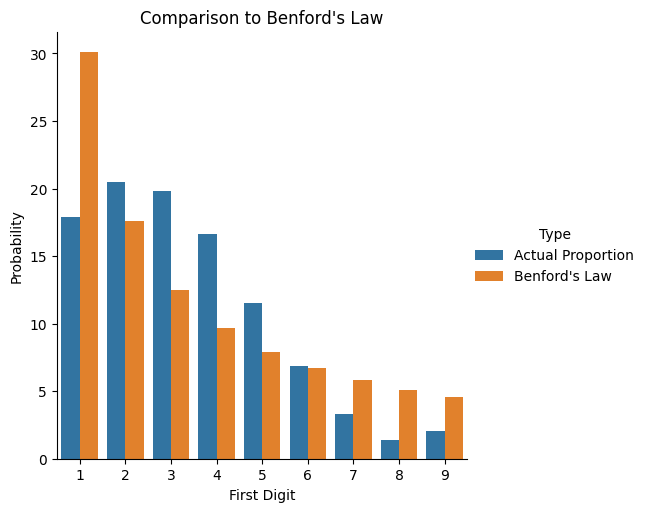

In [10]:
plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

Benford (user_id)

In [11]:
df_benford = df.copy()

In [12]:
df_benford['user_id'] = df_benford["user_id"].astype(str)
df_benford['first_digit'] = df_benford['user_id'].str.slice(0,1)
df_benford.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff_dt,days,seconds,quick_purchase,month_purchase,weekday_purchase,hour_of_the_day,period_of_the_day,risk_country,freq_device,freq_device_cat,country_count,freq_same_purchase,freq_same_purchase_cat,age_category,first_digit
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,52,4506682.0,0,April,Saturday,2,late night,Low Risk,1,1,1,1,1,< 40,2
1,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,0,Japan,68 days 23:28:22,68,5959702.0,0,April,Thursday,17,arvo,Low Risk,1,1,1,1,1,< 40,2
2,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,0,Japan,7 days 16:04:09,7,662649.0,0,August,Monday,5,early morning,Low Risk,1,1,1,1,1,40 - 49,8
3,28074,2015-07-03 09:31:29,2015-08-07 20:12:17,22,GQOICTLWVUQJR,Ads,Chrome,M,36,7.289345e+08,0,Japan,35 days 10:40:48,35,3062448.0,0,August,Friday,20,evening,Low Risk,1,1,1,1,1,< 40,2
4,135536,2015-05-03 22:40:07,2015-07-18 15:43:38,32,ITRXCOXKEQTAM,SEO,FireFox,M,37,2.097968e+09,0,Japan,75 days 17:03:31,75,6541411.0,0,July,Saturday,15,early arvo,Low Risk,2,2,1,1,1,< 40,1


In [13]:
# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])

temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)

temp = temp.drop(columns = ["level_0"])

temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

temp

,First Digit,Actual Proportion,Benford's Law
0,1,27.900498,30.103000
1,2,27.734396,17.609126
2,3,27.804542,12.493874
3,4,2.739028,9.691001
4,5,2.737043,7.918125
5,6,2.766160,6.694679
6,7,2.735719,5.799195
7,8,2.778072,5.115252
8,9,2.804542,4.575749


In [14]:
bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")
bf_law_df

,First Digit,Type,Probability
0,1,Actual Proportion,27.900498
1,2,Actual Proportion,27.734396
2,3,Actual Proportion,27.804542
3,4,Actual Proportion,2.739028
4,5,Actual Proportion,2.737043
5,6,Actual Proportion,2.766160
6,7,Actual Proportion,2.735719
7,8,Actual Proportion,2.778072
8,9,Actual Proportion,2.804542
9,1,Benford's Law,30.103000


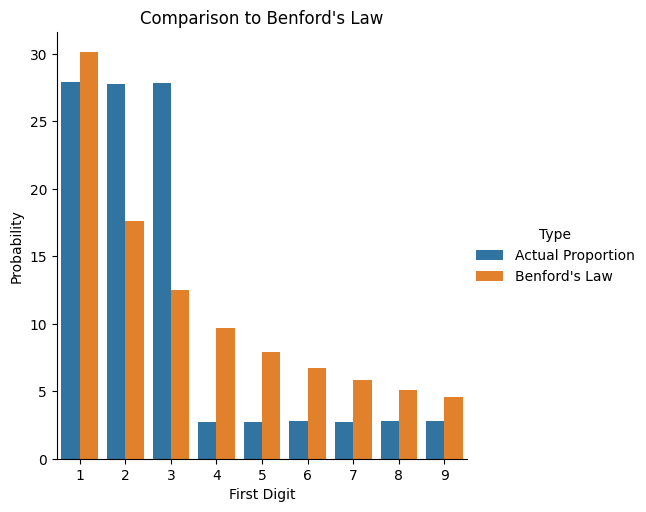

In [15]:
plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

#### Box Plot (Purchase Value VS Class)

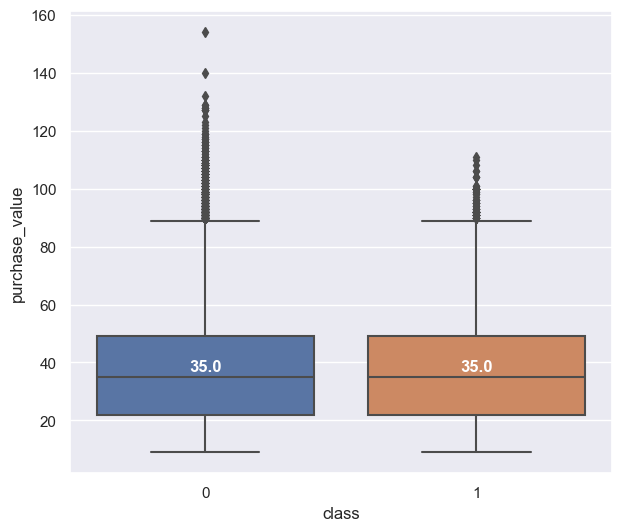

In [16]:
sns.set(rc={'figure.figsize':(7,6)})
box_plot = sns.boxplot(data=df , y='purchase_value', x='class')
medians = df.groupby(['class'])['purchase_value'].median()
vertical_offset = df['purchase_value'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')

Both boxplots have the similar shape and they also have the same median. 
Non fraudulent cases tend to have higher outliers.

#### Chi Square Test (Cat vs Cat)

In [31]:
cat_vars = [
    'source', 'browser', 'sex', 'class', 'country', 'quick_purchase', 'month_purchase', 'weekday_purchase', 'hour_of_the_day', 
    'period_of_the_day', 'risk_country', 'freq_device_cat', 'freq_same_purchase_cat', 'age_category'
    ]
    
num_vars = ['purchase_value', 'age', 'freq_device', 'country_count', 'freq_same_purchase']


In [55]:
p_values = []
chai_stats = []
for cat1 in cat_vars:
    for cat2 in cat_vars:
            crosstab = pd.crosstab(df[cat1], df[cat2])
            chai2, p_val, _, _ = stats.chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))

chisquare = pd.DataFrame(p_values, columns=['Categorical 1', 'Categorical 2', 'p-value'])
chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value')

Categorical 2,age_category,browser,class,country,freq_device_cat,freq_same_purchase_cat,hour_of_the_day,month_purchase,period_of_the_day,quick_purchase,risk_country,sex,source,weekday_purchase
Categorical 1,,,,,,,,,,,,,,
age_category,0.000000,4.229125e-02,1.414110e-01,6.571913e-01,1.857546e-03,4.626048e-03,4.544685e-02,5.446387e-02,4.099557e-01,8.499675e-04,9.257946e-02,7.233102e-01,5.079557e-02,3.343533e-01
browser,0.042291,0.000000e+00,4.916028e-09,1.187395e-07,2.575893e-21,1.127938e-21,4.737484e-06,7.727572e-09,6.921425e-03,1.415097e-18,1.032804e-03,3.165731e-01,3.108238e-03,2.347044e-03
class,0.141411,4.916028e-09,0.000000e+00,1.071777e-89,0.000000e+00,0.000000e+00,1.050437e-06,0.000000e+00,2.747742e-07,0.000000e+00,3.890454e-104,3.072654e-03,7.981991e-15,8.417415e-30
country,0.657191,1.187395e-07,1.071777e-89,0.000000e+00,0.000000e+00,0.000000e+00,2.288696e-45,1.437413e-61,4.997128e-10,2.648937e-201,0.000000e+00,2.372554e-04,2.898186e-03,1.021202e-07
freq_device_cat,0.001858,2.575893e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.211482e-111,0.000000e+00,2.725933e-42,0.000000e+00,2.430989e-223,5.661535e-11,6.985808e-16,8.744300e-67
freq_same_purchase_cat,0.004626,1.127938e-21,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.427300e-120,0.000000e+00,4.679947e-44,0.000000e+00,3.759977e-222,4.102457e-13,1.353868e-15,2.301713e-66
hour_of_the_day,0.045447,4.737484e-06,1.050437e-06,2.288696e-45,1.211482e-111,2.427300e-120,0.000000e+00,5.068522e-06,0.000000e+00,2.500534e-27,5.537348e-07,5.116383e-01,2.038176e-02,5.152999e-04
month_purchase,0.054464,7.727572e-09,0.000000e+00,1.437413e-61,0.000000e+00,0.000000e+00,5.068522e-06,0.000000e+00,2.106150e-06,0.000000e+00,6.205707e-116,4.459846e-01,4.701022e-01,0.000000e+00
period_of_the_day,0.409956,6.921425e-03,2.747742e-07,4.997128e-10,2.725933e-42,4.679947e-44,0.000000e+00,2.106150e-06,0.000000e+00,4.519019e-18,3.671658e-04,9.123388e-01,1.939466e-02,1.704061e-02


Text(0.5, 1.0, 'Correlation Heatmap (Cat vs Cat - Chi-square test)')

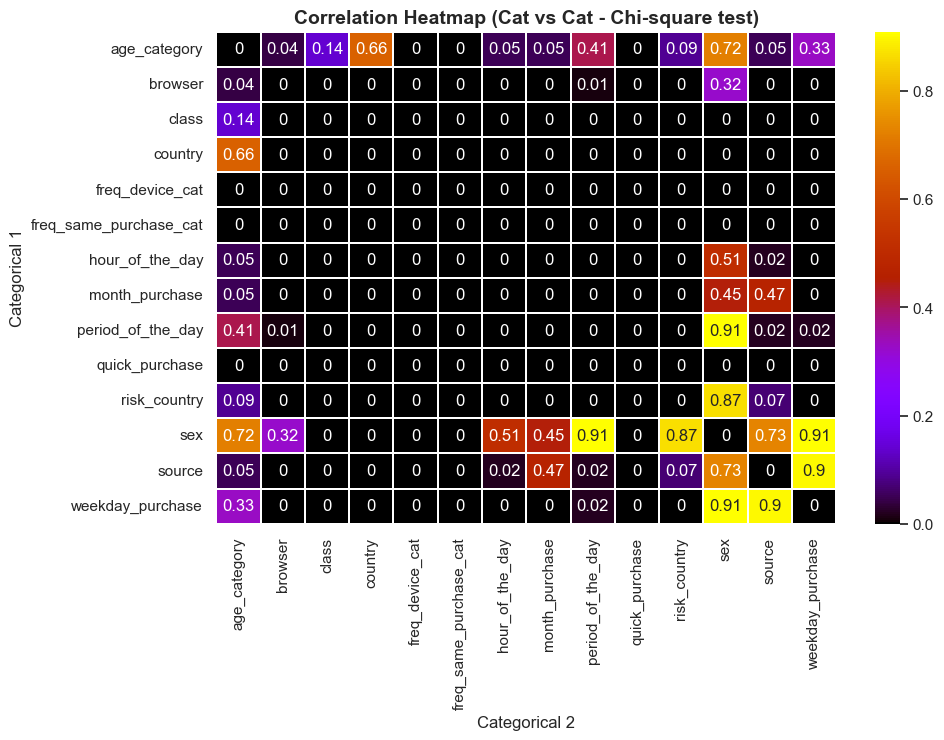

In [115]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value'),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap=cmap, # Color Map.
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

plt.title('Correlation Heatmap (Cat vs Cat - Chi-square test)', fontsize=14, fontweight='bold')

In [110]:
x = chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value')
# drop_cat = ['age_category', 'sex', 'source']
take_cat = ['sex', 'source', 'class', 'risk_country']
x = x[take_cat].loc[take_cat]
# x = x.drop(index=drop_cat, columns=drop_cat)
x

Categorical 2,sex,source,class,risk_country
Categorical 1,,,,
sex,0.000000,7.322453e-01,3.072654e-03,8.684887e-01
source,0.732245,0.000000e+00,7.981991e-15,6.932275e-02
class,0.003073,7.981991e-15,0.000000e+00,3.890454e-104
risk_country,0.868489,6.932275e-02,3.890454e-104,0.000000e+00


<AxesSubplot:xlabel='Categorical 2', ylabel='Categorical 1'>

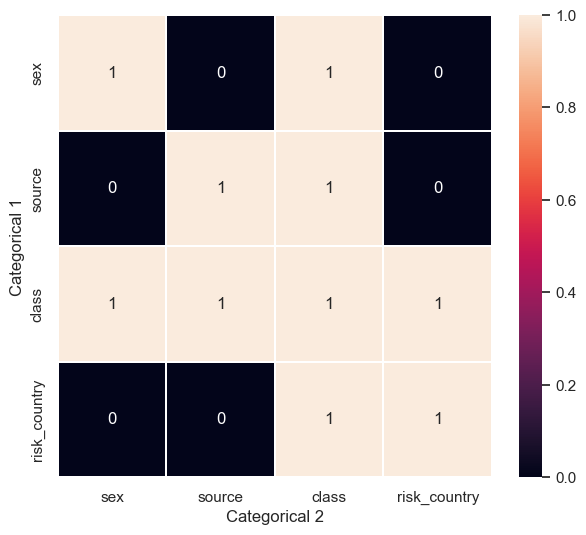

In [111]:
sns.heatmap(round(x,2) <= 0.05,
                 annot=True, 
                 linewidths=.05)

The null hypothesis states that there is no relationship between the two variables <br>
With that we have seleceted `risk_country`, `source` and `sex` from categorical variables as they are correlated to `class` but not with one another.

#### Correlation (Num vs Num)

Text(0.5, 1.0, 'Correlation Matrix')

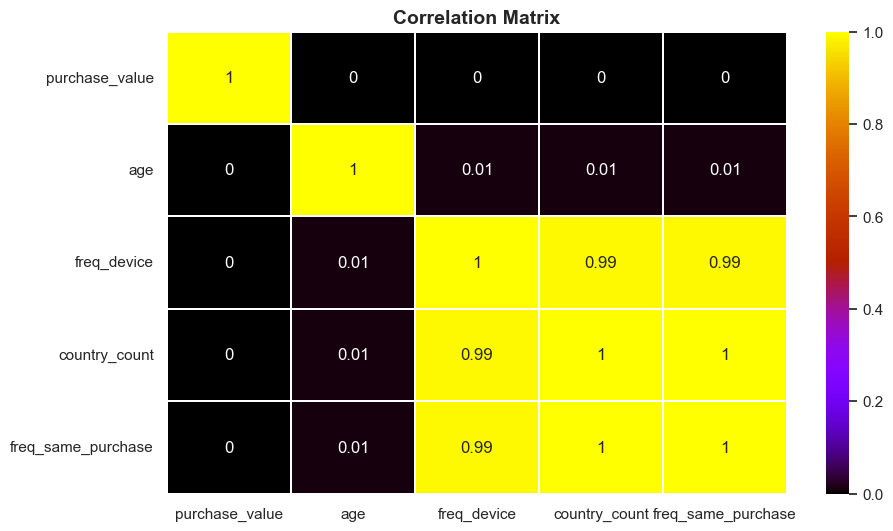

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
corrMatrix = df[num_vars].corr()
sns.heatmap(round(corrMatrix, 2), ax=ax,annot=True, cmap=cmap,linewidths=.05)

plt.title('Correlation Heatmap (Num vs Num - Correlation Matrix)', fontsize=14, fontweight='bold')


#### Anova Test (Cat vs Num)

In [116]:
results = []

for cat in take_cat:
    for num in num_vars:
        
        candidates = []
        for val in df[cat].unique():
            if len(df[df[cat]==val][num])>0:
                candidates.append(df[df[cat]==val][num])
                
        _, p_val = stats.f_oneway(*candidates)
        results.append((cat, num, p_val))

In [117]:
anova = pd.DataFrame(results, columns=['Categorical', 'Numerical', 'P-value'])
anova.pivot_table(index='Numerical', columns='Categorical')

P-value                                   
Categorical            class   risk_country       sex    source
Numerical                                                      
age                 0.010030   4.434293e-01  0.111598  0.371409
country_count       0.000000  1.138925e-210  0.012474  0.190180
freq_device         0.000000  1.611020e-215  0.008607  0.204530
freq_same_purchase  0.000000  9.642893e-219  0.010266  0.177899
purchase_value      0.694306   4.065688e-01  0.437897  0.985443

Text(0.5, 1.0, 'Correlation Heatmap (Num vs Cat - Anova test)')

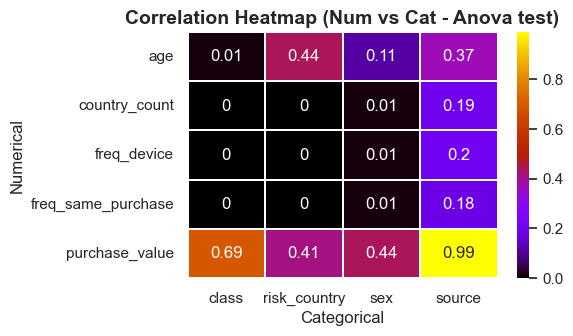

In [122]:
fig, ax = plt.subplots(1,1, figsize=(5,3))

hm = sns.heatmap(round(anova.pivot_table(index='Numerical', columns='Categorical', values='P-value'),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap=cmap, # Color Map.
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

plt.title('Correlation Heatmap (Num vs Cat - Anova test)', fontsize=14, fontweight='bold')

In [129]:
x = anova.pivot_table(index='Numerical', columns='Categorical', values='P-value')
# drop_cat = ['age_category', 'sex', 'source']
take_num = ['age']
x = x[take_cat].loc[take_num]
# x = x.drop(index=drop_cat, columns=drop_cat)
x

Categorical,sex,source,class,risk_country
Numerical,,,,
age,0.111598,0.371409,0.01003,0.443429


<AxesSubplot:xlabel='Categorical', ylabel='Numerical'>

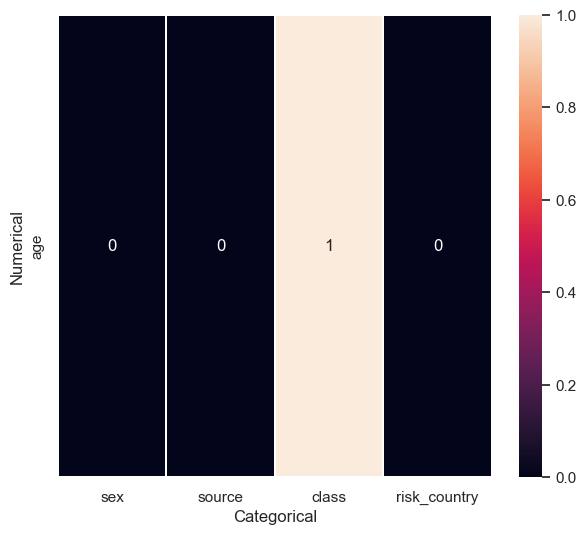

In [130]:
sns.heatmap(round(x,2) <= 0.05,
                 annot=True, 
                 linewidths=.05)

The null hypothesis states that there is no relationship between the two variables <br>
With that we have seleceted `age` from numerical variables as they are correlated to `class` but not with other categorical variables.

In conclusion, we have selected `age`, `risk_country`, `source` and `sex` during our feature selection

#### Train Test Split

In [150]:
X = df[['age', 'risk_country', 'source', 'sex']].reset_index(drop=True)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)